<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Ericson Estupiñan

***
## Procesos aleatorios

### PARTE 1

<div class="alert alert-block alert-info">
<b>a)</b> Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar
con filtros FIR o IIR, los que les parezcan convenientes.
    
¿Es óptimo el filtro elegido para detectar la información en forma confiable?

</div>

In [6]:
import numpy as np

tpsignal = np.load('signal.npy')
tppulse  = np.load('pulse.npy')

print('Signal and data information')

print("Signal size: {} samples".format(len(tpsignal)))
numBits = len(tpsignal)/20
print("Data size:   {} bits , {} Bytes".format(numBits, (len(tpsignal)/20)/8))
print("Pulse size:  {}".format(len(tppulse)))

Signal and data information
Signal size: 32560 samples
Data size:   1628.0 bits , 203.5 Bytes
Pulse size:  20


Text(0.5, 1.0, 'Pulso de modulación')

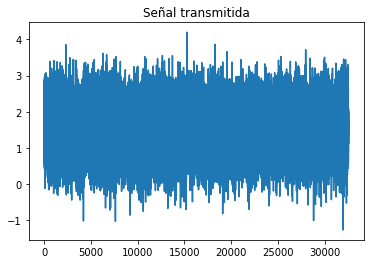

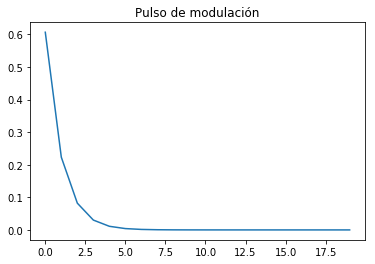

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tpsignal)
plt.title('Señal transmitida')

plt.figure()
plt.plot(tppulse)
plt.title('Pulso de modulación')

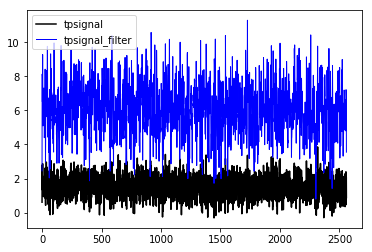

In [29]:
from scipy import signal
from scipy.fftpack import fft

# Variables
NBYTES = 16             # Numero de bytes
NSAMPLE = 160 * NBYTES # Numero de samples a demodular

# Filtro FIR
a = [1,1,0]
b = np.zeros(len(a))
b[0] = 1
tpsignal_filter = signal.filtfilt(a,b,tpsignal[0:NSAMPLE])

plt.figure()
plt.plot(tpsignal[:NSAMPLE], 'k-', label='tpsignal')
plt.plot(tpsignal_filter[:NSAMPLE], 'b-', linewidth=1, label='tpsignal_filter')
plt.legend(loc='best')


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> NO, aunque ayuda a filtrar altas frecuencias adicionadas por ruido. Se realizarón pruebas con otros filtros pasabajos pero sin tener buenos resultados.
</div>

<div class="alert alert-block alert-info">
<b>b)</b>  Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para
cada pulso y reconstruir la trama enviada. Nuevamente, ¿Es óptimo ese umbral?

</div>

In [37]:
sig_mean = np.mean(tpsignal_filter)
print("Mean filter signal: {}".format(sig_mean))

Mean filter signal: 6.086148754486432


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Se definio como umbral de dicision la media de la señal.
</div>

In [36]:
import bitstring as bs

numBits = int(NSAMPLE/20) 
bitstream = []
bytestream = []
byteCount = 0
bites = []

print('Se revisan los primeros 16 Bytes correspondientes a el header')
print('su valor debe ser igual a 0b10101100')
print('')

for i in range(numBits):
    sample =  tpsignal_filter[(i*20) + 1]
    byteCount += 1
    if (sample > sig_mean):
        bitstream.append(1)
        bites.append(1)
    else:
        bitstream.append(0)
        bites.append(0)
        
    if(byteCount == 8):
        bytestream.append(np.array(bites))
        bites = []
        byteCount = 0
        
for data in bytestream:    
    byte = bs.BitArray(data)
    print("0x{} 0b{} {}".format(str(byte.hex),str(byte.bin), str(byte))) 

Se revisan los primeros 16 Bytes correspondientes a el header
su valor debe ser igual a 0b10101100

0xac 0b10101100 0xac
0xad 0b10101101 0xad
0xad 0b10101101 0xad
0xfd 0b11111101 0xfd
0xec 0b11101100 0xec
0xbf 0b10111111 0xbf
0x2e 0b00101110 0x2e
0xb4 0b10110100 0xb4
0xac 0b10101100 0xac
0xac 0b10101100 0xac
0xac 0b10101100 0xac
0xac 0b10101100 0xac
0xae 0b10101110 0xae
0xac 0b10101100 0xac
0x2c 0b00101100 0x2c
0xad 0b10101101 0xad


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> NO, pero se logra demodular varios de los datos del header de forma correcta.
</div>